<a href="https://colab.research.google.com/github/number1angel/tphotel/blob/nico/hotel_vn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Importacion de librerias.
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
from sklearn.metrics import classification_report, RocCurveDisplay, ConfusionMatrixDisplay

In [2]:
# Cambio el estilo de los graficos que voy a crear con Seaborn.
sns.set(rc={'axes.facecolor': 'lavender'}, style='darkgrid')

# **VISUALIZACION DE DATOS**

In [3]:
# Cargo y leo el dataset.
df = pd.read_csv('hotel_bookings_demand_TF.csv')
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342.0,2015.0,July,NaN,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737.0,2015.0,July,27.0,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7.0,2015.0,July,27.0,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13.0,2015.0,July,27.0,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14.0,2015.0,July,27.0,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [4]:
# Informacion de los campos.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       115809 non-null  float64
 3   arrival_date_year               113421 non-null  float64
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        107451 non-null  float64
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

Quiero hacer una visualizacion de los campos numericos **babies**, **children** y **days_in_waiting_list** ya que dudo de su importancia en mi modelo.

Tambien con la variable categorica de **meal**, a ver que tanto infiere en una posible cancelacion de la reserva.

In [5]:
def tabla_frecuencias(df, columna):
    tabla = df[columna].value_counts(dropna=False).to_frame(name='count')
    tabla['percentage'] = (tabla['count'] / len(df)) * 100
    tabla['percentage'] = tabla['percentage'].round(2)
    return tabla

# comienzo con babies.
tabla_frecuencias(df, 'babies')

,count,percentage
babies,,
0,118473,99.23
1,900,0.75
2,15,0.01
10,1,0.00
9,1,0.00


*   El 99% de los casos es 0.
*   Solo hay 4 entradas distintas a 0 en el dataset.

**Definitivamente la elimino, es una entrada que no me va a sumar nada en el modelo**.

In [6]:
tabla_frecuencias(df, 'children')

,count,percentage
children,,
0.0,110796,92.80
1.0,4861,4.07
2.0,3652,3.06
3.0,76,0.06
NaN,4,0.00
10.0,1,0.00


*   El 92,8% de los casos es 0.
*   Solo hay 5 entradas distintas a 0 en el dataset.

**Podria eliminarla pero la dejo de onda como paraver una muy improbable pero posible relacion en la tasa de cancelacion**.

In [7]:
tabla_frecuencias(df, 'days_in_waiting_list')

,count,percentage
days_in_waiting_list,,
0,115692,96.90
39,227,0.19
58,164,0.14
44,141,0.12
31,127,0.11
...,...,...
81,1,0.00
92,1,0.00
74,1,0.00


*   El 96,9 de los casos es 0.
*   Hay 127 entradas distintas a 0 en el dataset.

**La gran mayoria en general es 0 (no esperan) pero hay muchos casos distintos entonces podria ser util en mi modelo. La dejo**.

In [8]:
def analizar_columna(df, columna):
    conteo = df[columna].value_counts().rename('count')
    tasa_cancelacion = df.groupby(columna)['is_canceled'].mean().rename('cancel_rate')
    tabla = pd.concat([conteo, tasa_cancelacion], axis=1)
    return tabla

# Me fijo la tasa de cancelacion en meal por cada categoria para ver si alguna tiene una mayor tasa a las demas.
tabla_meal = analizar_columna(df, 'meal')
print(tabla_meal)

           count  cancel_rate
meal                         
BB         92310     0.373849
HB         14463     0.344603
SC         10650     0.372394
Undefined   1169     0.244654
FB           798     0.598997


En la tabla **BB** **HB** y **SC** tienen tasas de cancelacion muy parecidas, entre el 0.34% y el 0.37% siendo logico ya que representan en cantidad mas del 95% del dataset.

**Undefined** puede ser por entradas erroneas asi que no es muy determinante.

**FB** tiene una tasa distinta pero representa menos del 5% del dataset con 798 casos asi que efectivamenbte una cancelacion le afectaria mucho mas que a las otras categorias.

Puedo confirmar a mi parecer entonces que la columna meal no hace a mi analisis objetivo. **La saco**.

# **ELIMINACION DE CAMPOS INNECESEARIOS**

In [9]:
columnas_a_eliminar = [
    'arrival_date_year',        # anualmente es dificil encontrar patrones
    'arrival_date_week_number', # semana del año (?? q me importa
    'babies',                   # analisis hecho arriba.
    'meal',                     # analisis hecho arriba.
    'assigned_room_type',       # dato engañoso porque eso se asigna en el momento que viene el huesped.
    'company',                  # demasiados valores nulos y tampoco es relevante
    'agent',                    # un ID que no me importa
    'reservation_status',       # TRAMPA justamente responde lo que estoy modelando.
    'reservation_status_date',  # -

]

df.drop(columns=[col for col in columnas_a_eliminar if col in df.columns], inplace=True)

Ademas de babies y meal, saco otras columnas muy especificas o irrelevantes a mi analisis.

In [10]:
# Chequeo campos post eliminacion..
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 23 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       115809 non-null  float64
 3   arrival_date_month              119390 non-null  object 
 4   arrival_date_day_of_month       119390 non-null  int64  
 5   stays_in_weekend_nights         119390 non-null  int64  
 6   stays_in_week_nights            119390 non-null  int64  
 7   adults                          119390 non-null  int64  
 8   children                        119386 non-null  float64
 9   country                         118902 non-null  object 
 10  market_segment                  119390 non-null  object 
 11  distribution_channel            119390 non-null  object 
 12  is_repeated_gues

Elimine 10 columnas.

# **RELLENO DE CAMPOS CON VALORES NULOS**

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 23 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       115809 non-null  float64
 3   arrival_date_month              119390 non-null  object 
 4   arrival_date_day_of_month       119390 non-null  int64  
 5   stays_in_weekend_nights         119390 non-null  int64  
 6   stays_in_week_nights            119390 non-null  int64  
 7   adults                          119390 non-null  int64  
 8   children                        119386 non-null  float64
 9   country                         118902 non-null  object 
 10  market_segment                  119390 non-null  object 
 11  distribution_channel            119390 non-null  object 
 12  is_repeated_gues

Variables con valores null:

*   **lead_time** -> 3581 nulos
*   **children**	-> 4 nulos
*   **country**	-> 488 nulos

Habria que trabajar esos campos.

In [12]:
# Imputo lead_time  y children con mediana (numerica)
df['lead_time'].fillna(df['lead_time'].median(), inplace=True)
df['children'].fillna(df['children'].median(), inplace=True)

# Imputo country con moda (categorica)
df['country'].fillna(df['country'].mode()[0], inplace=True)

Children es practicamente nada asi que los reemplazo cn la mediana que es cero.

Country tambien son pocos, los imputo con la moda que no me va a generar un sesgo en el analisis.

Lead_time son un poco mas por las dudas imputar con la mediana para no posiblemente afectar el analisis y conservar registros.

In [13]:
# checkingg
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 23 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  float64
 3   arrival_date_month              119390 non-null  object 
 4   arrival_date_day_of_month       119390 non-null  int64  
 5   stays_in_weekend_nights         119390 non-null  int64  
 6   stays_in_week_nights            119390 non-null  int64  
 7   adults                          119390 non-null  int64  
 8   children                        119390 non-null  float64
 9   country                         119390 non-null  object 
 10  market_segment                  119390 non-null  object 
 11  distribution_channel            119390 non-null  object 
 12  is_repeated_gues

# **CASOS IMPOSIBLES**

In [14]:
df[(df['adults'] == 0) & (df['children'] == 0)]

,hotel,is_canceled,lead_time,arrival_date_month,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,country,...,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests
2224,Resort Hotel,0,1.0,October,6,0,3,0,0.0,PRT,...,0,0,A,1,No Deposit,0,Transient-Party,0.00,0,0
2409,Resort Hotel,0,0.0,October,12,0,0,0,0.0,PRT,...,0,0,A,0,No Deposit,0,Transient,0.00,0,0
3181,Resort Hotel,0,36.0,November,20,1,2,0,0.0,ESP,...,0,0,A,0,No Deposit,0,Transient-Party,0.00,0,0
3684,Resort Hotel,0,165.0,December,30,1,4,0,0.0,PRT,...,0,0,A,1,No Deposit,122,Transient-Party,0.00,0,0
3708,Resort Hotel,0,165.0,December,30,2,4,0,0.0,PRT,...,0,0,A,1,No Deposit,122,Transient-Party,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115029,City Hotel,0,69.0,June,27,0,3,0,0.0,CHE,...,0,0,A,1,No Deposit,0,Transient,100.80,0,0
115091,City Hotel,0,1.0,June,30,0,1,0,0.0,PRT,...,0,0,E,0,No Deposit,0,Transient,0.00,1,1
116251,City Hotel,0,44.0,July,15,1,1,0,0.0,SWE,...,0,0,A,2,No Deposit,0,Transient,73.80,0,0
116534,City Hotel,0,2.0,July,15,2,5,0,0.0,RUS,...,0,0,A,1,No Deposit,0,Transient-Party,22.86,0,1


Imposible no pueden haber reservaciones para 0 personas....

**las elimino**.

In [15]:
df = df[~((df['adults'] == 0) & (df['children'] == 0))]

In [16]:
(df[['lead_time', 'adr', 'stays_in_week_nights', 'stays_in_weekend_nights']] < 0).any()

,0
lead_time,False
adr,True
stays_in_week_nights,False
stays_in_weekend_nights,False


Esos campos no pueden tener valores negativos.

En adr (precio total/cant de noches) el valor puede llegar a ser 0 (si la reserva fue cancelada o si hay algun arreglo particular en relacion al tipo de cliente y el hotel) pero definitivamente no puede ser 0 significaria que el pago o la cant de noches fue negativo. **REVISAR**

me dice que encontro unicamente en el campo adr (precio x noche) valores negativos. **Habria que eliminarlos**.

In [17]:
df = df[df['adr'] >= 0] #elimino los negativos

# **ERRORES DE ENTRADA EN VARIABLES CATEGORICAS**

In [18]:
for col in df.select_dtypes(include='object').columns:
    count_undef = df[col].str.lower().value_counts().get('undefined', 0)
    if count_undef > 0:
        print(f"Columna '{col}': 'Undefined' aparece {count_undef} veces.")

Columna 'market_segment': 'Undefined' aparece 2 veces.
Columna 'distribution_channel': 'Undefined' aparece 5 veces.


In [19]:
#Imputo los undefined con la moda
def obtener_moda_sin_undefined(col):
    mode = df[df[col] != 'Undefined'][col].mode()[0]
    return mode

def imputar_undefined_y_nulos(col):
    mode = obtener_moda_sin_undefined(col)
    df[col].replace('Undefined', mode, inplace=True)
    df[col].fillna(mode, inplace=True)

columnas = ['market_segment', 'distribution_channel']
for c in columnas:
    imputar_undefined_y_nulos(c)

In [20]:
for col in ['hotel', 'is_canceled', 'arrival_date_month', 'country', 'market_segment', 'distribution_channel', 'is_repeated_guest', 'reserved_room_type', 'deposit_type', 'customer_type']:
    print(f"--- {col} ---")
    print(df[col].value_counts(dropna=False))
    print()

--- hotel ---
hotel
City Hotel      79163
Resort Hotel    40046
Name: count, dtype: int64

--- is_canceled ---
is_canceled
0    75010
1    44199
Name: count, dtype: int64

--- arrival_date_month ---
arrival_date_month
August       13861
July         12644
May          11780
October      11147
April        11078
June         10929
September    10500
March         9767
February      8052
November      6771
December      6759
January       5921
Name: count, dtype: int64

--- country ---
country
PRT    48961
GBR    12119
FRA    10401
ESP     8560
DEU     7285
       ...  
MRT        1
KIR        1
SDN        1
ATF        1
SLE        1
Name: count, Length: 177, dtype: int64

--- market_segment ---
market_segment
Online TA        56410
Offline TA/TO    24182
Groups           19790
Direct           12582
Corporate         5282
Complementary      728
Aviation           235
Name: count, dtype: int64

--- distribution_channel ---
distribution_channel
TA/TO        97755
Direct       14610
Corpor

todas las variables categoricas estan en orden!

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 119209 entries, 0 to 119389
Data columns (total 23 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119209 non-null  object 
 1   is_canceled                     119209 non-null  int64  
 2   lead_time                       119209 non-null  float64
 3   arrival_date_month              119209 non-null  object 
 4   arrival_date_day_of_month       119209 non-null  int64  
 5   stays_in_weekend_nights         119209 non-null  int64  
 6   stays_in_week_nights            119209 non-null  int64  
 7   adults                          119209 non-null  int64  
 8   children                        119209 non-null  float64
 9   country                         119209 non-null  object 
 10  market_segment                  119209 non-null  object 
 11  distribution_channel            119209 non-null  object 
 12  is_repeated_guest    

# **ELIMINACION DE FILAS DUPLICADAS**

In [22]:
df.duplicated().sum()

np.int64(32322)

In [23]:
df = df.drop_duplicates()

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 86887 entries, 0 to 119389
Data columns (total 23 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   hotel                           86887 non-null  object 
 1   is_canceled                     86887 non-null  int64  
 2   lead_time                       86887 non-null  float64
 3   arrival_date_month              86887 non-null  object 
 4   arrival_date_day_of_month       86887 non-null  int64  
 5   stays_in_weekend_nights         86887 non-null  int64  
 6   stays_in_week_nights            86887 non-null  int64  
 7   adults                          86887 non-null  int64  
 8   children                        86887 non-null  float64
 9   country                         86887 non-null  object 
 10  market_segment                  86887 non-null  object 
 11  distribution_channel            86887 non-null  object 
 12  is_repeated_guest               8688

In [25]:
119209 - 32322

86887

**Efectivamente se eliminaron todas las filas duplicadas.**

# **OUTLIERS**

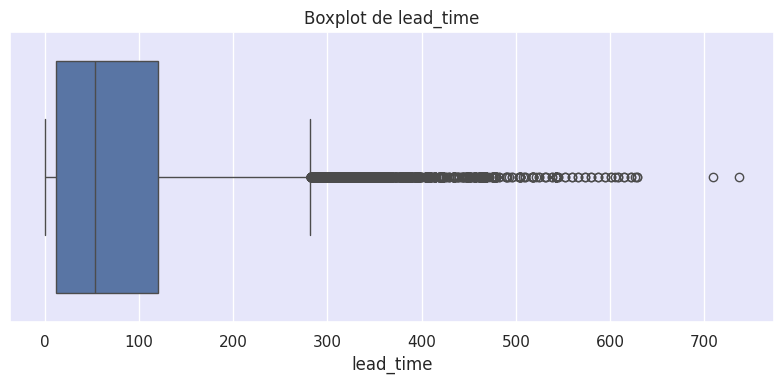

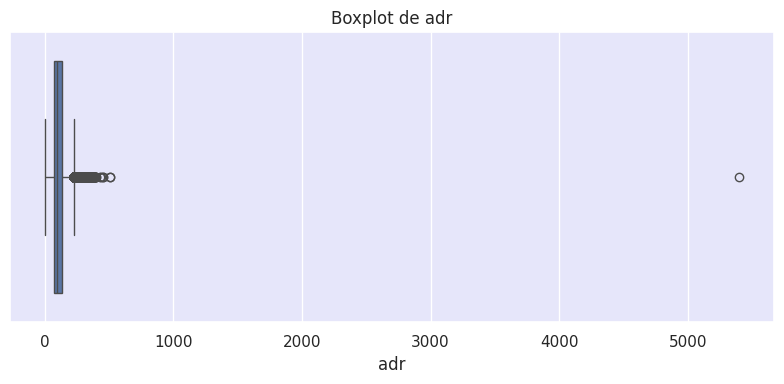

In [26]:
def boxplots_por_lista(df, lista_columnas):
    for col in lista_columnas:
        plt.figure(figsize=(8, 4))
        sns.boxplot(x=df[col])
        plt.title(f'Boxplot de {col}')
        plt.tight_layout()
        plt.show()

numericas_no_categoricas = [
    'lead_time',
    'adr',
]

boxplots_por_lista(df, numericas_no_categoricas)

In [27]:
Q1 = df['lead_time'].quantile(0.25)
Q3 = df['lead_time'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers_lead_time = df[(df['lead_time'] < lower_bound) | (df['lead_time'] > upper_bound)]

print(f"Number of outliers in 'lead_time': {len(outliers_lead_time)}")
print("Outliers in 'lead_time':")
display(outliers_lead_time[['lead_time']].head())

Number of outliers in 'lead_time': 2805
Outliers in 'lead_time':


,lead_time
0,342.0
1,737.0
81,368.0
82,364.0
85,324.0


In [28]:
# Calculate the median of the non-outlier data in 'lead_time'
median_lead_time_non_outlier = df[(df['lead_time'] >= lower_bound) & (df['lead_time'] <= upper_bound)]['lead_time'].median()

# Impute the outliers with the calculated median
df.loc[outliers_lead_time.index, 'lead_time'] = median_lead_time_non_outlier

# Verify the imputation by checking the 'lead_time' values in the rows that were outliers
print("First 5 'lead_time' values in the rows that were outliers after imputation:")
display(df.loc[outliers_lead_time.index, 'lead_time'].head())

First 5 'lead_time' values in the rows that were outliers after imputation:


,lead_time
0,49.0
1,49.0
81,49.0
82,49.0
85,49.0


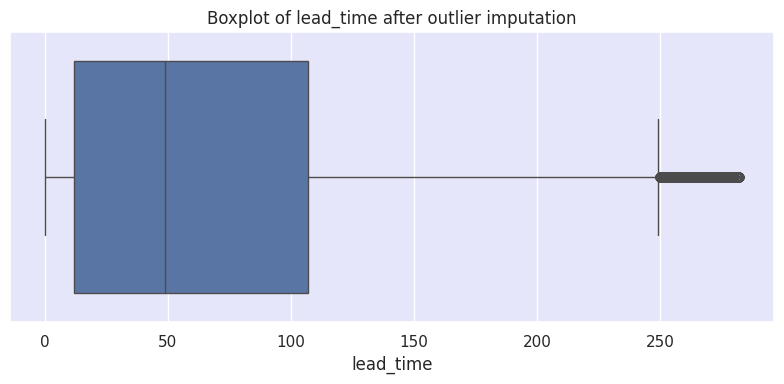

In [29]:
plt.figure(figsize=(8, 4))
sns.boxplot(x=df['lead_time'])
plt.title('Boxplot of lead_time after outlier imputation')
plt.tight_layout()
plt.show()

In [30]:
Q1 = df['adr'].quantile(0.25)
Q3 = df['adr'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers_adr = df[(df['adr'] < lower_bound) | (df['adr'] > upper_bound)]

print(f"Number of outliers in 'adr': {len(outliers_adr)}")
print("Outliers in 'adr':")
display(outliers_adr[['adr']].head())

Number of outliers in 'adr': 2502
Outliers in 'adr':


,adr
396,230.67
523,249.00
526,241.50
584,240.64
641,233.00


In [31]:
# Calculate the median of the non-outlier data in 'adr'
median_adr_non_outlier = df[(df['adr'] >= lower_bound) & (df['adr'] <= upper_bound)]['adr'].median()

# Impute the outliers with the calculated median
df.loc[outliers_adr.index, 'adr'] = median_adr_non_outlier

# Verify the imputation by checking the 'adr' values in the rows that were outliers
print("First 5 'adr' values in the rows that were outliers after imputation:")
display(df.loc[outliers_adr.index, 'adr'].head())

First 5 'adr' values in the rows that were outliers after imputation:


,adr
396,96.9
523,96.9
526,96.9
584,96.9
641,96.9


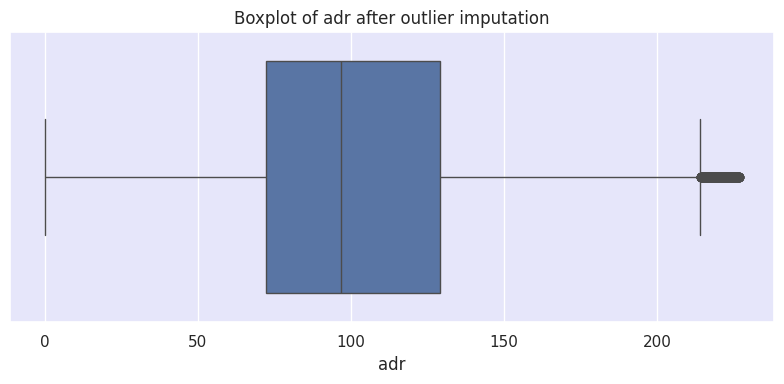

In [32]:
plt.figure(figsize=(8, 4))
sns.boxplot(x=df['adr'])
plt.title('Boxplot of adr after outlier imputation')
plt.tight_layout()
plt.show()

**Ya fueron tratados los outliers de las variables numericas continuas del dataset.**

# **ENCODING**

In [33]:
# Aseguro que sean de tipo object(string) todas las categoricas
categorical_columns = [
    'hotel',
    'is_canceled',
    'arrival_date_month',
    'country',
    'market_segment',
    'distribution_channel',
    'is_repeated_guest',
    'reserved_room_type',
    'deposit_type',
    'customer_type',
]
for column in categorical_columns:
    if column in df.columns:
        df[column] = df[column].astype(str)

# Verifico
df.dtypes

,0
hotel,object
is_canceled,object
lead_time,float64
arrival_date_month,object
arrival_date_day_of_month,int64
stays_in_weekend_nights,int64
stays_in_week_nights,int64
adults,int64
children,float64
country,object


**Este paso me sirve para confirmar que mi modelo nova a tomar como magnitudes las variables categoricas de tipo numerica.**

In [34]:
# columnas categóricas a codificar
categorical_columns = [
    'hotel',
    'arrival_date_month',
    'country',
    'market_segment',
    'distribution_channel',
    'reserved_room_type',
    'deposit_type',
    'customer_type'
]

# One-Hot Encoding
df_encoded = pd.get_dummies(df, columns=categorical_columns, drop_first=True)

No hace falta las categoricas que ya son numericas

In [35]:
df_encoded.info()
df_encoded.head()

<class 'pandas.core.frame.DataFrame'>
Index: 86887 entries, 0 to 119389
Columns: 225 entries, is_canceled to customer_type_Transient-Party
dtypes: bool(210), float64(3), int64(10), object(2)
memory usage: 30.0+ MB


,is_canceled,lead_time,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,...,reserved_room_type_E,reserved_room_type_F,reserved_room_type_G,reserved_room_type_H,reserved_room_type_L,deposit_type_Non Refund,deposit_type_Refundable,customer_type_Group,customer_type_Transient,customer_type_Transient-Party
0,0,49.0,1,0,0,2,0.0,0,0,0,...,False,False,False,False,False,False,False,False,True,False
1,0,49.0,1,0,0,2,0.0,0,0,0,...,False,False,False,False,False,False,False,False,True,False
2,0,7.0,1,0,1,1,0.0,0,0,0,...,False,False,False,False,False,False,False,False,True,False
3,0,13.0,1,0,1,1,0.0,0,0,0,...,False,False,False,False,False,False,False,False,True,False
4,0,14.0,1,0,2,2,0.0,0,0,0,...,False,False,False,False,False,False,False,False,True,False
